# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Завантаження набору даних
raw_df = pd.read_csv('data/tweet_sentiment_train.csv.zip')

In [3]:
# Перевівка структури набору
raw_df.shape

(27481, 4)

In [4]:
# Виведення 5-ти перших рядків
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
# Виведення основної статистики (типи полів, кількість пропущених значень)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


- Маємо набір у 27481 рядків і 4 стовпці.
- Усі совпці типу `object`.
- Стовпці `text` і `selected_text` мають по одному порожньому запису.

In [6]:
# Видалення записів, в яких є пропущені значення
raw_df.dropna(inplace = True, ignore_index = True)

In [7]:
# Перевірка кількості пропущених значень у полях після операції видалення таких записів
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


- Пропущених значень більше немає.

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [8]:
raw_df['sentiment'].value_counts().sort_values(ascending = False)

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [9]:
raw_df['sentiment'].value_counts(normalize = True).sort_values(ascending = False) * 100

sentiment
neutral     40.454876
positive    31.229985
negative    28.315138
Name: proportion, dtype: float64

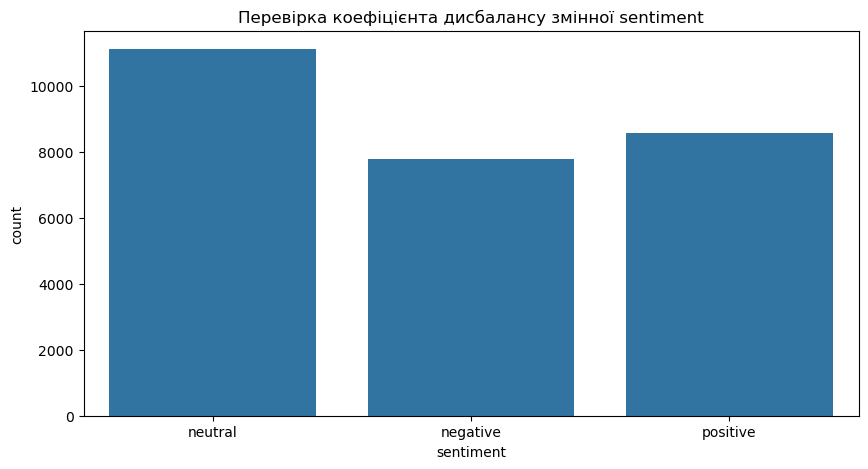

In [10]:
plt.figure(figsize = (10,5))
sns.countplot(x = raw_df['sentiment'], data = raw_df)
plt.title('Перевірка коефіцієнта дисбалансу змінної sentiment')
plt.show()

In [11]:
# Додавання стовпця з довжиною тексту в символах
raw_df['text_length'] = raw_df.text.apply(lambda x: len(x))
raw_df.head()

,textID,text,selected_text,sentiment,text_length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me...,bullying me,negative,25
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75


In [12]:
raw_df['text_length'].nunique()

139

In [13]:
raw_df['text_length'].value_counts()

text_length
41     308
48     301
46     301
42     298
45     295
      ... 
4        8
3        5
139      4
141      2
140      1
Name: count, Length: 139, dtype: int64

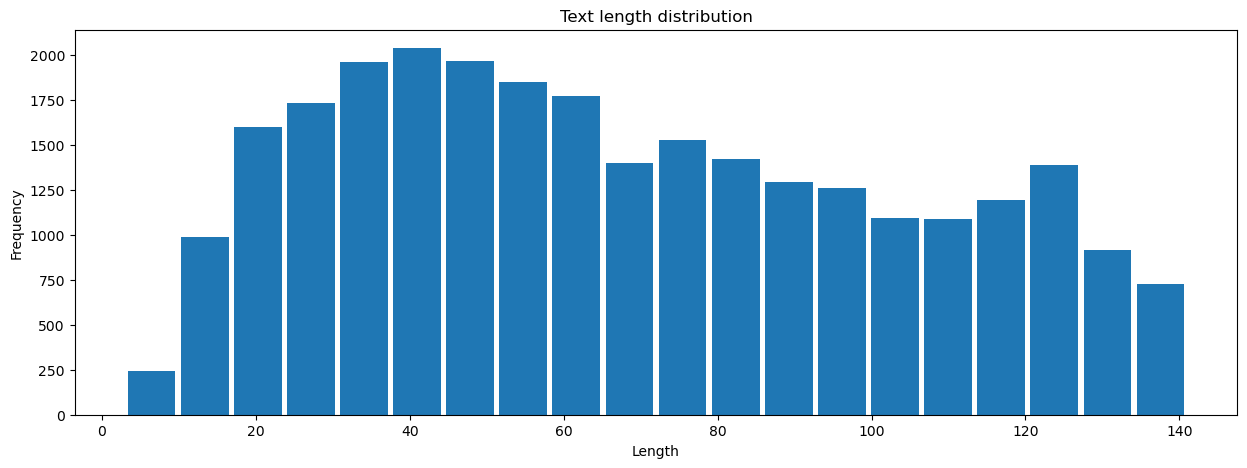

In [14]:
# Візуалізація розподілу довжин текстів
plt.figure(figsize = (15, 5))
plt.hist(raw_df['text_length'], bins = 20, rwidth = 0.9)
plt.title('Text length distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show();

- Маємо 3 класи: `neutral`, `negative`, `positive`.
- Спостерігається незначний дисбаланс класів з переважанням класу `neutral`.
- Зустрічаються тексти 139-ти різних довжин.
- Найбільше текстів довжиною у 41 символ. Таких є 308 штук.
- Розподіл довжин текстів скошений вправо. Зі збільшенням довжини тексту кількість таких, довгих, твітів зменшується. 

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [15]:
nltk.download('punkt_tab')
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

# Функція токенізації, видалення стоп-слів і стеммінгу
def tokenize_stopwords_stem(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in english_stopwords]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

vectorizer = CountVectorizer(lowercase = True,
                             tokenizer = tokenize_stopwords_stem,
                             max_features = 1000)

vectorizer.fit(raw_df.text)
print(f"Vocabulary length is {len(vectorizer.vocabulary_)} words.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Admin\anaconda3\envs\py3921\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulary length is 1000 words.


In [16]:
vectorizer.get_feature_names_out()[:100]

array(['!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '--',
       '.', '..', '...', '....', '.....', '......', '.......', '/', '1',
       '10', '100', '11', '12', '15', '1st', '2', '20', '2day', '2nd',
       '3', '30', '4', '4th', '5', '6', '7', '8', ':', ';', '<', '=', '>',
       '?', '@', '[', ']', '_', '`', 'abl', 'absolut', 'account', 'ach',
       'actual', 'ad', 'add', 'addict', 'afternoon', 'age', 'ago', 'agre',
       'ah', 'ahh', 'ahhh', 'aint', 'air', 'airport', 'album', 'almost',
       'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'although',
       'alway', 'amaz', 'american', 'anim', 'annoy', 'anoth', 'answer',
       'anymor', 'anyon', 'anyth', 'anytim', 'anyway', 'apart', 'app',
       'appar', 'appl', 'appreci', 'arm', 'around', 'arriv', 'art', 'ask'],
      dtype=object)

In [17]:
vectorizer.get_feature_names_out()[900:]

array(['tv', 'tweet', 'twilight', 'twit', 'twitter', 'two', 'type', 'u',
       'ugh', 'uk', 'understand', 'unfortun', 'updat', 'upload', 'upset',
       'ur', 'us', 'use', 'usual', 'vacat', 'vega', 'version', 'via',
       'vid', 'video', 'visit', 'voic', 'vote', 'w/', 'wait', 'wake',
       'walk', 'wan', 'want', 'war', 'warm', 'wash', 'wast', 'wat',
       'watch', 'water', 'way', 'wear', 'weather', 'web', 'websit', 'wed',
       'week', 'weekend', 'weird', 'welcom', 'well', 'went', 'what',
       'whatev', 'white', 'whole', 'wife', 'win', 'window', 'wine',
       'wish', 'wit', 'without', 'woke', 'wolverin', 'wonder', 'wont',
       'woo', 'word', 'work', 'world', 'worri', 'wors', 'worst', 'worth',
       'would', 'wow', 'write', 'wrong', 'wtf', 'x', 'xd', 'xoxo', 'ya',
       'yay', 'yea', 'yeah', 'year', 'yep', 'yes', 'yesterday', 'yet',
       'yo', 'young', 'youtub', 'yr', 'yum', 'yummi', 'yup'], dtype=object)

In [18]:
inputs = vectorizer.transform(raw_df.text)
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [19]:
train_index, test_index = train_test_split(raw_df.index, test_size = 0.3, random_state = 42)

In [20]:
X_train_bow = inputs[train_index]
X_test_bow = inputs[test_index]
y_train = raw_df.loc[train_index, 'sentiment']
y_test = raw_df.loc[test_index, 'sentiment']

In [21]:
X_train_bow.shape

(19236, 1000)

In [22]:
X_test_bow.shape

(8244, 1000)

In [23]:
# Кодування текстових міток класів

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [24]:
MAX_ITER = 2000

**LogisticRegression**

In [25]:
log_reg = LogisticRegression(max_iter = MAX_ITER, solver = 'sag', random_state = 42)
log_reg.fit(X_train_bow, y_train)

log_reg_predictions = log_reg.predict(X_test_bow)
print(classification_report(y_test, log_reg_predictions))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64      2356
           1       0.63      0.75      0.68      3343
           2       0.76      0.72      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



**OneVsRestClassifier**

In [26]:
log_reg_ovr = OneVsRestClassifier(LogisticRegression(max_iter = MAX_ITER, solver = 'sag', random_state = 42))
log_reg_ovr.fit(X_train_bow, y_train)

log_reg_ovr_predictions = log_reg_ovr.predict(X_test_bow)
print(classification_report(y_test, log_reg_ovr_predictions))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64      2356
           1       0.64      0.74      0.69      3343
           2       0.75      0.73      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



**RandomForestClassifier**

In [27]:
rf = OneVsRestClassifier(RandomForestClassifier(max_leaf_nodes = 200, random_state = 42))
rf.fit(X_train_bow, y_train)

rf_predictions = rf.predict(X_test_bow)
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.75      0.53      0.62      2356
           1       0.64      0.76      0.69      3343
           2       0.74      0.75      0.75      2545

    accuracy                           0.69      8244
   macro avg       0.71      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



**XGBClassifier**

In [28]:
xgb = XGBClassifier(max_depth = 10, random_state = 42, n_jobs=-1)
xgb.fit(X_train_bow, y_train)

xgb_predictions = xgb.predict(X_test_bow)
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64      2356
           1       0.65      0.77      0.70      3343
           2       0.76      0.74      0.75      2545

    accuracy                           0.70      8244
   macro avg       0.72      0.69      0.70      8244
weighted avg       0.71      0.70      0.70      8244



- Судячи з метрик f1-score macro avg, найкращу точність на тестовому наборі показує модель XGBClassifier (попередні три моделі демонструють приблизно однакову, гіршу, точність). 

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [29]:
feature_importance = pd.Series(xgb.feature_importances_, index = vectorizer.get_feature_names_out(), name = 'imp').sort_values(ascending = False)

In [30]:
# Найбільш важливі слова-ознаки

feature_importance.index[:10]

Index(['happi', 'thank', 'great', 'nice', 'hurt', 'sad', 'suck', 'hate',
       'awesom', 'bore'],
      dtype='object')

In [31]:
# Найменш важливі слова-ознаки

feature_importance.index[-10:]

Index(['eh', 'em', 'exact', 'email', 'especi', 'etc', 'event', 'soooo',
       'everi', 'facebook'],
      dtype='object')

- Слова, які найбільше впливають на визначення сентименту, дійсно чітко асоціюються з визначенням "позитивний" (happi, thank, great, nice, awesom) чи "негативний" (hurt, sad, suck, hate, bore). Серед слів, що мають найбільший вплив, відсутні слова нейтрального характеру (тому поки не зовсім зрозуміло як модель ідентифікує нейтральний клас).
- Слова, що мають найменший вплив, справді не можна розділити за визначенням "позитивний"/"негативний"/"нейтральний".

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [32]:
tfidf_vectorizer = TfidfVectorizer(lowercase = True,
                                   tokenizer = tokenize_stopwords_stem,
                                   max_features = 1000
                                  )

tfidf_vectorizer.fit(raw_df.text)
inputs = tfidf_vectorizer.transform(raw_df.text)
inputs.shape

C:\Users\Admin\anaconda3\envs\py3921\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(27480, 1000)

In [33]:
X_train_tfidf = inputs[train_index]
X_test_tfidf = inputs[test_index]

In [34]:
xgb = XGBClassifier(max_depth = 10, random_state = 42, n_jobs=-1)
xgb.fit(X_train_tfidf, y_train)

xgb_predictions = xgb.predict(X_test_tfidf)
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63      2356
           1       0.64      0.76      0.69      3343
           2       0.76      0.72      0.74      2545

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.70      0.69      0.69      8244



In [35]:
feature_importance = pd.Series(xgb.feature_importances_, index = tfidf_vectorizer.get_feature_names_out(), name = 'imp').sort_values(ascending = False)
feature_importance.index[:10]

Index(['happi', 'thank', 'nice', 'great', 'ugh', 'awesom', 'sad', 'suck',
       'bore', 'hate'],
      dtype='object')

- Порівнюючи метрику f1-score macro avg, можна зробити висновок, що тренування класифікатора Хgboost з векторизацією тексту методом Bag of Words дає більш точний результат (значення метрики 0,70 проти 0,69).
- При тренуваннні класифікатора з TF-IDF векторами список токенів, які найбільше впливаютьна результат, практично співпадає зі списком найважливіших токенів при Bag of Words векторизації (є відмінність в одному слові зі списку 10-ти найважливіших токенів і незначна різниця в порядку їх важливості).

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [36]:
xgb_predictions = le.inverse_transform(xgb_predictions)
test_df = pd.DataFrame(raw_df.loc[test_index, ['text', 'sentiment']])
test_df['pred'] = xgb_predictions
test_df.head()

,text,sentiment,pred
1588,Enjoy! Family trumps everything,positive,positive
10413,--of them kinda turns me off of it all. And ...,negative,neutral
6561,Clive it`s my birthday pat me http://apps.fac...,neutral,neutral
2602,congrats hey,positive,neutral
4003,is texting,neutral,neutral


In [37]:
err_df = test_df[test_df['sentiment'] != test_df['pred']]
err_df.head()

,text,sentiment,pred
10413,--of them kinda turns me off of it all. And ...,negative,neutral
2602,congrats hey,positive,neutral
25013,oooh sounds yummy. If you get a chance to ta...,positive,neutral
6717,At work... What a miserable day,negative,neutral
2830,I wish I had company,negative,positive


In [38]:
err_df[err_df['sentiment'] == 'positive'].head(10)

,text,sentiment,pred
2602,congrats hey,positive,neutral
25013,oooh sounds yummy. If you get a chance to ta...,positive,neutral
4890,xD hello that`s an important date!,positive,neutral
17381,FYI no internets until THURSTAG!!!! after satu...,positive,negative
17117,is helping making a twitter account,positive,neutral
1227,I LLLOOOVVVEEE ICARLY,positive,neutral
20330,it always rains right after i get my car washed,positive,neutral
14603,45Th st pub anyone tonight? Dont want to be a ...,positive,negative
18846,I just got home. i bought twiggies and a toot...,positive,neutral
312,DUSTBIN BABY ON AT 11.30 Cannot wait x,positive,neutral


In [39]:
err_df[err_df['sentiment'] == 'negative'].head(10)

,text,sentiment,pred
10413,--of them kinda turns me off of it all. And ...,negative,neutral
6717,At work... What a miserable day,negative,neutral
2830,I wish I had company,negative,positive
21209,i`m on my mobile so it won`t let me but i ca...,negative,neutral
16792,Intel gfx driver situation much better with re...,negative,positive
15660,I burnt my arm. (just thought you should know),negative,neutral
24796,No FAIR!,negative,neutral
4097,**** being broke on the day Guitar Hero Metall...,negative,neutral
20027,Yep! Tail between legs!,negative,neutral
23913,waiting to go to the movies later for my 6th m...,negative,neutral


In [40]:
err_df[err_df['sentiment'] == 'neutral'].head(10)

,text,sentiment,pred
19670,Avoided cinder blocks! Safe in NY area.. But D...,neutral,negative
13346,My cat died of kidney failure during my math t...,neutral,positive
20883,Is sad clint hurdle got released. I liked him,neutral,negative
8786,"oh i wish my dear Michael, i wish",neutral,positive
24375,"haha! thanks, Tiff it went well, but they W...",neutral,positive
4101,Had to cancel subscriptions today to NZZ and E...,neutral,negative
15582,http://twitpic.com/67kb6 - Sad day! What a g...,neutral,negative
4400,cleaning cleaning cleaning today then working ...,neutral,positive
11326,RAIN why must you come 'after' I flat iron my ...,neutral,positive
15280,- i can do 'Nana' or 'Nana Rocks' for you in ...,neutral,positive


Модель помиляється у випадках:
- виразів, які мають стале негативне значення, але всі слова взяті окремо не мають негативного характеру (приклад: `I wish I had company`). Можливе рішення – врахувати сталі вирази, ідіоми, фразові дієслова у моделі.
- помилок в написанні (перекручуванні) слів, в результаті чого їх неможливо інтерпретувати як негативні чи позитивні (приклад: `I LLLOOOVVVEEE ICARLY`). Можливе рішення – додати в препроцесинг крок, який обрізатиме послідовність однакових символів, що йдуть один за одним (скорочувати до одного). Але це ризик зіпсувати слова, які дійсно мають подвоєння літер.
- нерозуміння контексту, інтонації, як у прикладі `haha! thanks, Tiff it went well, but they W...`, який є нейтральним, але модель оцінила як позитивний. Ймовірно, наявність слів `haha`, `thanks`, `well` змусило модель це зробити, але вона не врахувала слова `but` після усіх позитивних слів (бо навіть не бачила цього слова, ми його видалили як стоп-слово). Можливо, до словника варто включити більше слів, які дозволять ловити настрої.  

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model